**Подключение библиотек и скриптов**


In [381]:
import numpy as np
import pandas as pd
import io
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

### Загрузка данных
Описание датасета:
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [382]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,nan,0,11,B,"184,966.93"
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,"300,009.45"
2,4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,"220,925.91"
3,5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,"1,084.00",0,5,B,"175,616.23"
4,10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,"2,078.00",2,4,B,"150,226.53"


In [383]:
df_train.shape, df_test.shape

((10000, 20), (5000, 19))

### Получение информации о данных

In [384]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [385]:
df_test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [386]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,"5,000.00","8,412.60","4,832.67",1.00,"4,221.75","8,320.50","12,598.25","16,795.00"
DistrictId,"5,000.00",51.28,44.18,0.00,21.00,37.00,77.00,212.00
Rooms,"5,000.00",1.91,0.84,0.00,1.00,2.00,2.00,17.00
Square,"5,000.00",56.45,19.09,1.38,41.91,52.92,66.29,223.45
LifeSquare,"3,959.00",36.16,17.83,0.33,23.09,32.93,45.17,303.07
KitchenSquare,"5,000.00",5.98,9.95,0.00,1.00,6.00,9.00,620.00
Floor,"5,000.00",8.63,5.48,1.00,4.00,7.00,12.00,78.00
HouseFloor,"5,000.00",12.60,6.79,0.00,9.00,12.00,17.00,99.00
HouseYear,"5,000.00","1,984.39",18.57,"1,908.00","1,973.00","1,977.00","2,000.00","2,020.00"
Ecology_1,"5,000.00",0.12,0.12,0.00,0.02,0.07,0.20,0.52


*Разберемся с объектами*

In [387]:
df_train.describe(include='object')

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


ID района делаем объектом, чтобы модель не думала, что это число

In [388]:
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

Категориальные признаки приводим к бинарным

In [389]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

df_train[feature_bin_names] = df_train[feature_bin_names].replace({'A':0, 'B':1})
df_test[feature_bin_names] = df_test[feature_bin_names].replace({'A':0, 'B':1})

Обработка пропусков

Жилая площадь заполнена не у всех. Вычислим отношение Общей площади к Жилой площади для тех, где она известна. Возьмем медиану и на ее основе вычислим Жилую площадь там, где она неизвестна

In [390]:
df_train['Full_to_Life'] = df_train['Square'] / df_train['LifeSquare']
df_train['LifeSquare'].fillna((df_train['Square'] / df_train['Full_to_Life'].median()), inplace=True)

df_test['LifeSquare'].fillna((df_test['Square'] / df_train['Full_to_Life'].median()), inplace=True)

In [391]:
df_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Full_to_Life     2113
dtype: int64

Пропущенные Healthcare_1 заполним средним Healthcare по району.

In [392]:
mean_hc1_by_district = df_train.groupby("DistrictId").Healthcare_1.agg(['mean'])
mean_hc1_by_district.columns = ['avg']
mean_hc1_by_district.reset_index(level='DistrictId', inplace=True)

In [393]:
df_train_new = pd.merge(df_train, mean_hc1_by_district, on='DistrictId', how='inner')
df_train_new['Healthcare_1'].fillna((df_train_new['avg']), inplace=True)

In [394]:
df_test_new = pd.merge(df_test, mean_hc1_by_district, on='DistrictId', how='left')
df_test_new['Healthcare_1'].fillna((df_test_new['avg']), inplace=True)

In [395]:
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   4089 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Есть районы, по которым даже средний неизвестен. Их Helthcare заполним общим средним

In [396]:
df_train_new.loc[df_train_new['Healthcare_1'].isna(), 'Healthcare_1'] = df_train_new['Healthcare_1'].median()
df_test_new.loc[df_test_new['Healthcare_1'].isna(), 'Healthcare_1'] = df_train_new['Healthcare_1'].median()

In [397]:
df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Удалим вспомогательные столбцы Full_to_Life и avg

In [398]:
df_train_new.drop(columns=['Full_to_Life', 'avg'], inplace=True)

In [399]:
df_test_new.drop(columns=['avg'], inplace=True)

Проверим, что теперь все данные заполнены

In [400]:
df_train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [401]:
df_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Анализ выбросов

In [402]:
df_train_new.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,"10,000.00","8,383.41","4,859.02",0.00,"4,169.50","8,394.50","12,592.50","16,798.00"
Rooms,"10,000.00",1.89,0.84,0.00,1.00,2.00,2.00,19.00
Square,"10,000.00",56.32,21.06,1.14,41.77,52.51,65.90,641.07
LifeSquare,"10,000.00",37.21,76.86,0.37,24.24,33.27,44.87,"7,480.59"
KitchenSquare,"10,000.00",6.27,28.56,0.00,1.00,6.00,9.00,"2,014.00"
Floor,"10,000.00",8.53,5.24,1.00,4.00,7.00,12.00,42.00
HouseFloor,"10,000.00",12.61,6.78,0.00,9.00,13.00,17.00,117.00
HouseYear,"10,000.00","3,990.17","200,500.26","1,910.00","1,974.00","1,977.00","2,001.00","20,052,011.00"
Ecology_1,"10,000.00",0.12,0.12,0.00,0.02,0.08,0.20,0.52
Ecology_2,"10,000.00",0.99,0.10,0.00,1.00,1.00,1.00,1.00


Rooms

In [403]:
df_train_new[(df_train_new['Rooms'] > 5) | (df_train_new['Rooms'] < 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
483,14003,99,6.00,59.41,38.70,6.00,7,9.00,1969,0.03,1,1,66,10573,1,"1,322.00",3,8,1,"229,661.96"
828,8491,1,19.00,42.01,21.78,7.00,17,17.00,2014,0.01,1,1,1,264,0,228.77,0,1,1,"78,364.62"
1998,770,28,0.00,49.48,30.56,0.00,16,0.00,2015,0.12,1,1,30,6207,1,"1,183.00",1,0,1,"217,009.34"
2206,5927,57,10.00,59.06,36.22,10.00,22,22.00,2002,0.09,1,1,74,19083,2,"1,288.27",5,15,1,"317,265.32"
2439,12638,27,0.00,138.43,136.22,0.00,4,3.00,2016,0.08,1,1,11,3097,0,770.00,0,0,1,"268,394.74"
2489,7917,27,0.00,212.93,211.23,0.00,2,3.00,2008,0.21,1,1,9,1892,0,770.00,0,1,1,"302,211.26"
2517,7317,27,0.00,41.79,25.81,0.00,13,0.00,1977,0.21,1,1,9,1892,0,770.00,0,1,1,"98,129.98"
2748,3224,27,0.00,2.38,0.87,0.00,1,0.00,1977,0.02,1,1,2,469,0,770.00,0,0,1,"126,596.94"
3052,9443,27,0.00,87.76,85.13,0.00,5,15.00,1977,0.21,1,1,9,1892,0,770.00,0,1,1,"219,281.92"
4537,3159,88,0.00,38.70,19.35,9.00,9,16.00,1982,0.13,1,1,43,8429,3,770.00,3,9,1,"158,998.11"


Обнаружено, что у 12 квартир количество комнат 0 или больше 5. Заменим эти данные на медиану.

In [404]:
df_train_new.loc[(df_train_new['Rooms'] > 5)|(df_train_new['Rooms'] < 1), 'Rooms'] = df_train_new['Rooms'].mode()[0]
df_test_new.loc[(df_test_new['Rooms'] > 5)|(df_test_new['Rooms'] < 1), 'Rooms'] = df_train_new['Rooms'].mode()[0] 

Обработка площадей

In [405]:
df_train_new[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.32,37.21,6.27
std,21.06,76.86,28.56
min,1.14,0.37,0.00
25%,41.77,24.24,1.00
50%,52.51,33.27,6.00
75%,65.90,44.87,9.00
max,641.07,"7,480.59","2,014.00"


In [406]:
df_train_new.loc[(df_train_new['KitchenSquare'] > 100) | \
             (df_train_new['KitchenSquare'] > df_train_new['Square']),
             'KitchenSquare'] = df_train_new['KitchenSquare'].median()

df_test_new.loc[(df_test_new['KitchenSquare'] > 100) | \
            (df_test_new['KitchenSquare'] > df_test_new['Square']),
            'KitchenSquare'] = df_train_new['KitchenSquare'].median()

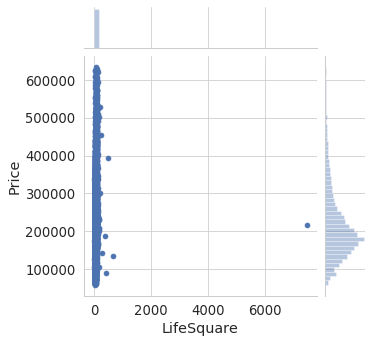

In [407]:
sns.jointplot(df_train_new['LifeSquare'], df_train_new['Price'], kind='scatter', height=5);

In [408]:
df_train_new.loc[(df_train_new['LifeSquare'] > 400), 'LifeSquare'] = \
        df_train_new['LifeSquare'].median()

df_test_new.loc[(df_test_new['LifeSquare'] > 400), 'LifeSquare'] = \
        df_train_new['LifeSquare'].median()

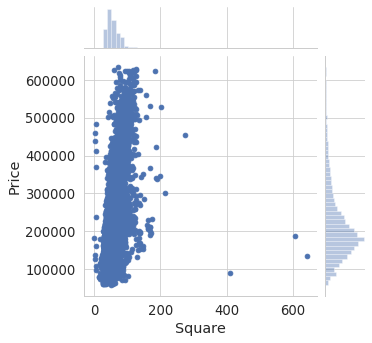

In [409]:
sns.jointplot(df_train_new['Square'], df_train_new['Price'], kind='scatter', height=5);

In [410]:
df_train_new.loc[(df_train_new['Square'] > 400) | (df_train_new['Square'] < 6), 'Square'] = \
            df_train_new['Square'].median()

df_test_new.loc[(df_test_new['Square'] > 400) | (df_test_new['Square'] < 6), 'Square'] = \
            df_train_new['Square'].median()

In [411]:
len(df_train_new[(df_train_new['Square'] < df_train_new['LifeSquare'] + df_train_new['KitchenSquare'])])

832

In [412]:
df_train_new.loc[(df_train_new['Square'] < df_train_new['LifeSquare'] + df_train_new['KitchenSquare']), 'Square'] = \
    df_train_new['LifeSquare'] + df_train_new['KitchenSquare']

df_test_new.loc[(df_test_new['Square'] < df_test_new['LifeSquare'] + df_test_new['KitchenSquare']), 'Square'] = \
    df_test_new['LifeSquare'] + df_test_new['KitchenSquare']

In [413]:
df_train_new[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,"10,000.00","10,000.00","10,000.00"
mean,56.78,36.33,5.83
std,19.81,17.27,4.70
min,16.12,0.37,0.00
25%,42.12,24.24,1.00
50%,52.95,33.27,6.00
75%,66.35,44.86,9.00
max,374.42,373.42,96.00


Обработка этажей

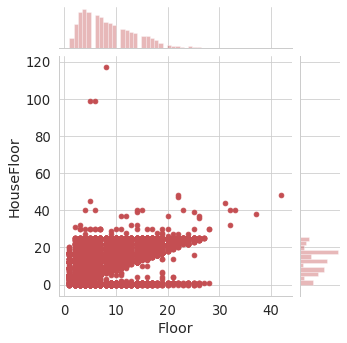

In [414]:
sns.jointplot(df_train_new['Floor'], df_train_new['HouseFloor'], kind='scatter', height=5, color='r');

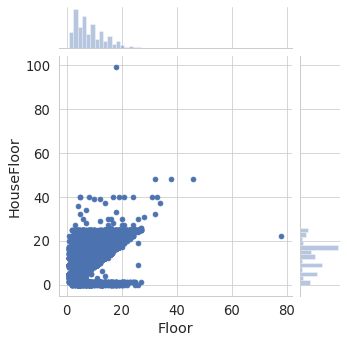

In [415]:
sns.jointplot(df_test_new['Floor'], df_test_new['HouseFloor'], kind='scatter', height=5, color='b');

In [416]:
df_train_new.loc[df_train_new['HouseFloor'] == 0, 'HouseFloor'] = df_train_new['HouseFloor'].mode()[0]
df_test_new.loc[df_test_new['HouseFloor'] == 0, 'HouseFloor'] = df_test_new['HouseFloor'].mode()[0]

In [417]:
df_train_new.loc[df_train_new['HouseFloor'] > 50, 'HouseFloor'] = df_train_new['HouseFloor'].mode()[0]
df_test_new.loc[df_test_new['HouseFloor'] > 50, 'HouseFloor'] = df_train_new['HouseFloor'].mode()[0]

In [418]:
floor_outliers_train = df_train_new.loc[df_train_new['Floor'] > df_train_new['HouseFloor']].index
floor_outliers_test = df_test_new.loc[df_test_new['Floor'] > df_test_new['HouseFloor']].index

Этажность дома не сильно влияет на цену. Но всё же попробую навести с ней порядок. Этаж квартиры терять не хотелось бы, потому приравняю этажность к этажу

In [419]:
df_train_new.loc[floor_outliers_train, 'HouseFloor'] = df_train_new.loc[floor_outliers_train, 'Floor']
df_test_new.loc[floor_outliers_test, 'HouseFloor'] = df_test_new.loc[floor_outliers_test, 'Floor']

Год постройки

In [420]:
df_train_new.loc[df_train_new['HouseYear'] > 2020, 'HouseYear']

7205    20052011
9738        4968
Name: HouseYear, dtype: int64

In [421]:
df_train_new.loc[df_train_new['HouseYear'] == 20052011, 'HouseYear'] = 2011
df_train_new.loc[df_train_new['HouseYear'] == 4968, 'HouseYear'] = 2020

Новые признаки

In [460]:
df_train_new['PriceOneRoom'] = df_train_new['Price'] / df_train_new['Rooms']

price_by_district = df_train_new.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'median'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

df_train_new = df_train_new.merge(price_by_district, on=['DistrictId'], how='left').set_index(df_train_new.index)
df_test_new = df_test_new.merge(price_by_district, on=['DistrictId'], how='left').set_index(df_test_new.index)

In [462]:
df_test_new['PriceOneRoomByDistrict'].fillna(df_test_new['PriceOneRoomByDistrict'].median(), inplace=True)

Работа с моделью

In [464]:
target_name = ['Price']
feature_names = [
             'DistrictId',
             'Rooms',
             'PriceOneRoomByDistrict',
#             'DistrictSize',
#             'RoomSquare',
             'Square',
             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
             'Ecology_2',
             'Ecology_3',
             'Social_1',
             'Social_2',
             'Social_3',
             'Healthcare_1',
             'Helthcare_2',
             'Shops_1',
             'Shops_2',
]

In [465]:
X = df_train_new[feature_names]
y = df_train_new[target_name]

X_test = df_test_new[feature_names]

In [466]:
forest = RandomForestRegressor(max_depth=19, 
                               max_features=5, 
                               n_estimators=400,
                               random_state=42)

In [467]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

R2: 0.74778


Прогноз

In [475]:
forest.fit(X, y)
y_pred = forest.predict(X_test)

preds = pd.DataFrame()
#preds['Id'] = X_test.index
preds['Id'] = df_test_new['Id']
preds['Price'] = y_pred

In [478]:
preds.to_csv('submission.csv', index=False)